# Project: Identification of Pneumonia CXR 
## Data Analysis on train-validation and test set
### Author: L. Saetta, December 2020, last update: 08/01/2021

In this Notebook **we analyze only data used during the training and the test** of our model

The list of images selected for train is in: train-submission3.csv
The list for test in: test-submission3.csv

In [1]:
# Need version 11 of seaborn
# Restart kernel after install !
!pip install --upgrade seaborn >> /dev/null

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from itertools import chain
import glob

sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# need version 11 of seaborn
assert sns.__version__ >= '0.11.0'

In [3]:
#
# Plotting functions
#
def plot_histo_ages(df):
    BINS = 20
    # limit [0, 100]
    BINRANGE = (0, 100)

    plt.figure(figsize=(20, 6))

    plt.subplot(1,3,1)
    plt.title('All patients')
    sns.histplot(df['Patient Age'], binrange = BINRANGE, bins = BINS);

    condition = df['Patient Gender'] == 'F'
    plt.subplot(1,3,2)
    plt.title('Only female')
    sns.histplot(df.loc[condition, 'Patient Age'], binrange = BINRANGE, bins = BINS);
    
    condition = df['Patient Gender'] == 'M'
    plt.subplot(1,3,3)
    plt.title('Only male')
    sns.histplot(df.loc[condition, 'Patient Age'], binrange = BINRANGE, bins = BINS);

def plot_histo_gender(df):
    # must take into accoun that there are multiple CXR per patients
    count_sex = df.groupby(['Patient Gender']).size()

    print(count_sex)
    print('Female: F, Male: M')
    
    plt.title('Gender distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    sns.barplot(y = count_sex.values, x  = ['F','M']);
    
def plot_histo_position(df):
    count_view = df.groupby(['View Position']).size()

    print(count_view)
    print('')

    plt.title('Position View distribution')
    plt.xlabel('View')
    plt.ylabel('Count')
    sns.barplot(y = count_view.values, x  = ['AP','PA']);

def plot_histo_pneumonia(df):
    count_view = df.groupby(['Pneumonia']).size()

    print(count_view)
    print('')

    plt.title('Distribution of pneumonia')
    plt.xlabel('Pneumonia?')
    plt.ylabel('Count')
    sns.barplot(y = count_view.values, x  = [0,1]);

In [4]:
def aggregate_patient(df):
    # build a new dataframe, aggregated at patient level
    # for demographic analysis
    # with cols: Patient ID, gender, age
    # no multiple rows per patient
    patients_id = df['Patient ID'].unique()
    
    patients_df = pd.DataFrame(patients_id, columns = ['Patient ID'])
    
    patients_df['Temp_gender'] = df.groupby(['Patient ID'])['Patient Gender'].agg('unique').values
    # remove the array, there is a single gender value
    patients_df['Patient Gender'] = patients_df['Temp_gender'].map(lambda x: x[0])
    patients_df = patients_df.drop(['Temp_gender'], axis = 1)
    
    patients_df['Patient Age'] = df.groupby(['Patient ID'])['Patient Age'].agg('max').values
    
    return patients_df

In [5]:
DIR_METADATA = './metadata'

TRAIN_FILE = DIR_METADATA + '/train-submission3.csv'
TEST_FILE = DIR_METADATA + '/test-submission3.csv'
FULL_FILE = DIR_METADATA + '/Data_Entry_2017.csv'

## EDA on training set

In [6]:
# the file with the complete list of images and their metadata
full_df = pd.read_csv(FULL_FILE)
# contains only image_name and label for images selected for train set
train_df = pd.read_csv(TRAIN_FILE)
# contains only image_name and label for images selected for test set
test_df = pd.read_csv(TEST_FILE)

# remove useless column
full_df.drop(['Unnamed: 11', 'OriginalImage[Width', 'Height]', 
              'OriginalImagePixelSpacing[x', 'y]'], axis = 1, inplace=True)

In [8]:
# select from full_df only rows in train:
train_df_extended = full_df[full_df['Image Index'].isin(train_df['image_name'].values)]

# we can have multiple images per patient, therefore before demographics we must aggregate
patients_train_df = aggregate_patient(train_df_extended)

In [9]:
### Compute # of patients
n_patients = train_df_extended['Patient ID'].nunique()

print('The number of distinct patients is:', n_patients)

The number of distinct patients is: 1896


### Distribution of Gender

Patient Gender
F     825
M    1071
dtype: int64
Female: F, Male: M


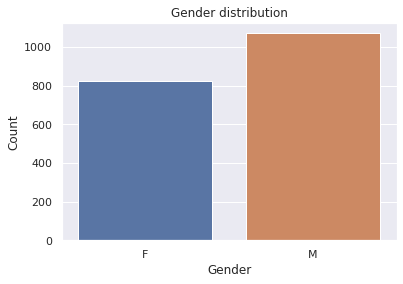

In [10]:
# counts female and male patients
plot_histo_gender(patients_train_df)

### the same distribution of the FULL dataset

### Distribution of Ages

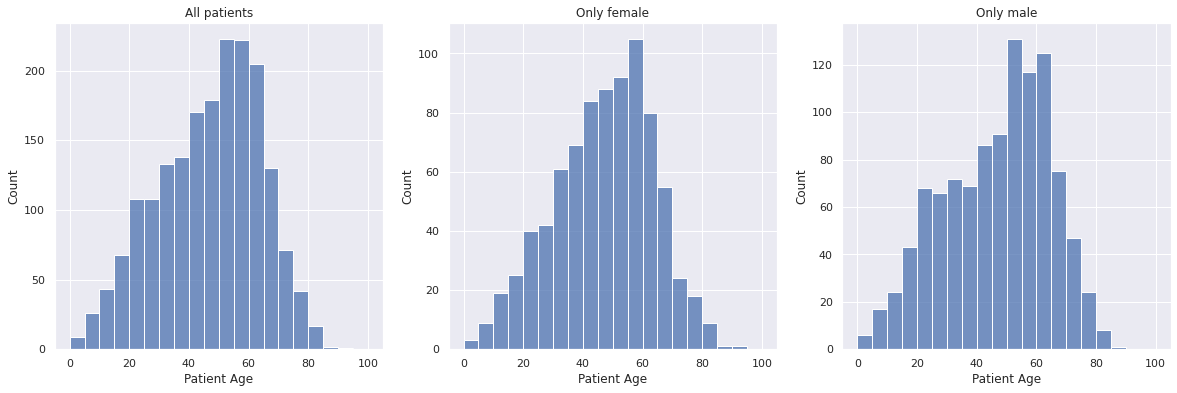

In [11]:
# plot histogram of Ages (consider only 0-100 range)
plot_histo_ages(patients_train_df)

### almost the same distribution of the full dataset

### Distribution of Patients View Positions (AP, PA)

View Position
AP    1204
PA    1340
dtype: int64



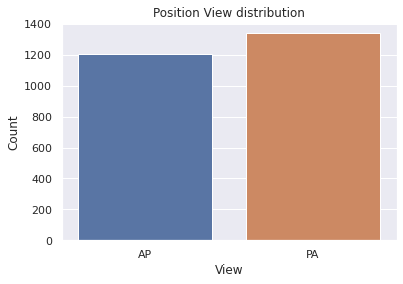

In [12]:
# this one is computed on the dataframe with images
plot_histo_position(train_df_extended)

### almost the same distribution of the FULL dataset. A small difference not significant.

### Check if the dataset is balanced

Pneumonia
0.0    1272
1.0    1272
dtype: int64



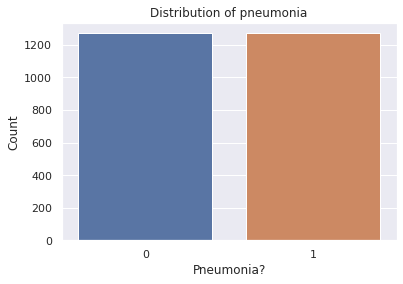

In [13]:
train_df['Pneumonia'] = train_df['label']

plot_histo_pneumonia(train_df)

### The train dataset is balanced !

## Test set EDA

In [14]:
test_df_extended = full_df[full_df['Image Index'].isin(test_df['image_name'].values)]

# aggregate
patients_test_df = aggregate_patient(test_df_extended)

In [15]:
### Compute # of patients
n_patients = test_df_extended['Patient ID'].nunique()

print('The number of distinct patients is:', n_patients)

The number of distinct patients is: 569


### Distribution of Gender

Patient Gender
F    253
M    316
dtype: int64
Female: F, Male: M


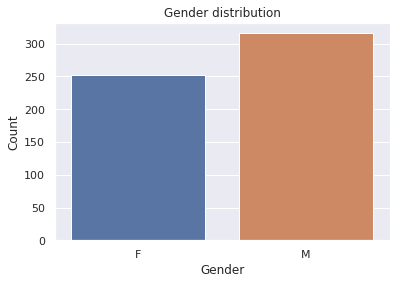

In [16]:
# counts female and male patients
plot_histo_gender(patients_test_df)

### The same distribution of the train dataset. The same consideration is valid for the following plots.

### Distribution of Ages

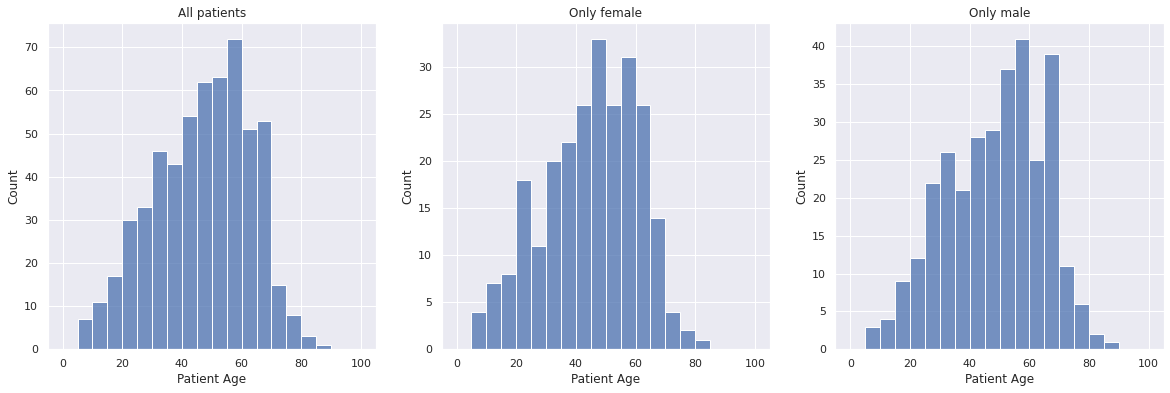

In [17]:
# plot histogram of Ages (consider only 0-100 range)
plot_histo_ages(patients_test_df)

### Distribution of Patients View Positions (AP, PA)

View Position
AP    276
PA    360
dtype: int64



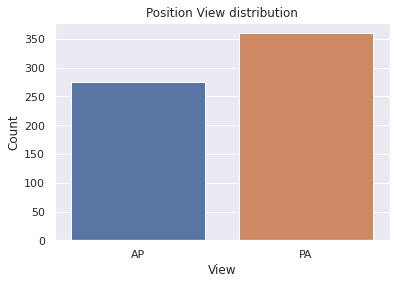

In [18]:
plot_histo_position(test_df_extended)

### Check the distribution of pneumonia: test dataset is not balanced !

Pneumonia
0.0    477
1.0    159
dtype: int64



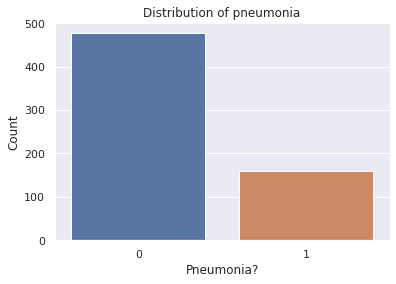

In [19]:
test_df['Pneumonia'] = test_df['label']

plot_histo_pneumonia(test_df)

### Check that there is no intersection between train and test dataset

In [20]:
# No common Patien IT between TRain and Test set. NO "Data leakage" possible
key = 'Patient ID'

assert len(set(train_df_extended[key].values).intersection(test_df_extended[key].values)) == 0

### OK: no intersection between train and test dataset